# Replicating ResNet paper: Deep Residual Learning for Image Recognition

## Preparing the data

The data that will be used is ImageNet 100: (per class)
* 1300 **train** images
* 100 **val** images 


In [20]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 Ti (UUID: GPU-ff183205-244d-e5aa-6214-59c049bddd64)


In [21]:
import tensorflow as tf
import keras
import numpy as np
from keras import layers, optimizers, callbacks, utils
from keras.losses import SparseCategoricalCrossentropy

In [22]:
BATCH_SIZE = 32 # to 256
IMG_HEIGHT = 224
IMG_WIDTH  = 224

In [5]:
train_dir = "archive/train.X/"
val_dir   = "archive/val.X/"

In [6]:
train_ds = utils.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256)
)
val_ds   = utils.image_dataset_from_directory(
    val_dir,
    image_size=(256, 256)
)

Found 130000 files belonging to 100 classes.


2024-08-12 19:28:30.883232: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-12 19:28:31.068956: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-12 19:28:31.072266: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 5000 files belonging to 100 classes.


In [7]:
class_names = train_ds.class_names
class_names[:10]

['American alligator, Alligator mississipiensis',
 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 'Dungeness crab, Cancer magister',
 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
 'agama',
 'albatross, mollymawk',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'banded gecko',
 'barn spider, Araneus cavaticus']

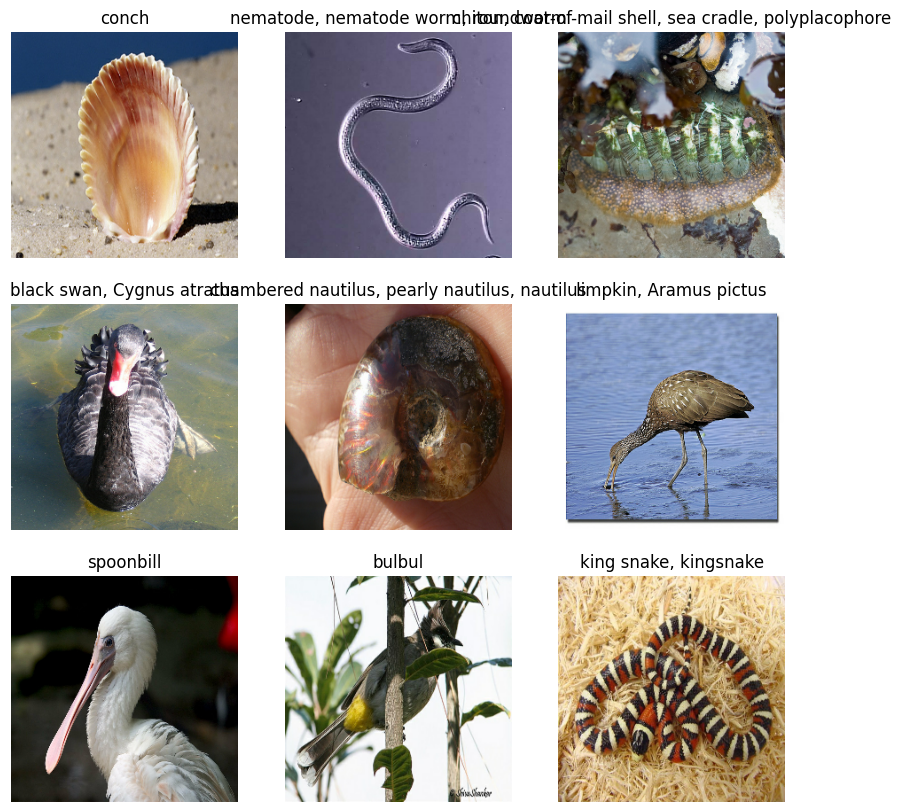

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off");

## Normalize & Prefetch datasets

### Normalize

In [9]:
normalization_layer = layers.Rescaling(1/255.)
train_norm_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_norm_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

### Prefetch

In [10]:
train_norm_ds = train_norm_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_norm_ds = val_norm_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [11]:
# layers.RandomCrop RandomFlip RandomRotation

In [23]:
class ResidualLayer(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.f_a, self.f_b, self.f_c = filters

        self.conv_2a = layers.Conv2D(self.f_a, 1, activation="relu")
        self.bn_a = layers.BatchNormalization()

        self.conv_2b = layers.Conv2D(self.f_b, 3, activation="relu", padding="same")
        self.bn_b = layers.BatchNormalization()
        
        self.conv_2c = layers.Conv2D(self.f_c, 1, activation="relu")
        self.bn_c = layers.BatchNormalization()

    def call(self, inputs, training=False):
        x = self.conv_2a(inputs)
        x = self.bn_a(x, training=training)

        x = self.conv_2b(x)
        x = self.bn_b(x, training=training)

        x = self.conv_2c(x)
        x = self.bn_c(x, training=training)

        return x
        

In [26]:
model_input = layers.Input((32, 32, 3), dtype=tf.float32)

conv_2x = layers.Conv2D(64, 7, strides=2, activation='relu')(model_input)
maxpool_x = layers.MaxPooling2D((3, 3), strides=2)(conv_2x)

residual_1a = ResidualLayer([64, 64, 64], name="1_a")(maxpool_x)
residual_1b = ResidualLayer([64, 64, 256], name="1_b")(residual_1a)
residual_1c = ResidualLayer([64, 64, 256], name="1_c")(residual_1b)

residual_2a = ResidualLayer([128, 128, 512], name="2_a")(residual_1c)
residual_2b = ResidualLayer([128, 128, 512], name="2_b")(residual_2a)
residual_2c = ResidualLayer([128, 128, 512], name="2_c")(residual_2b)
residual_2d = ResidualLayer([128, 128, 512], name="2_d")(residual_2c)

residual_3a = ResidualLayer([256, 256, 1024], name="3_a")(residual_2d)
residual_3b = ResidualLayer([256, 256, 1024], name="3_b")(residual_3a)
residual_3c = ResidualLayer([256, 256, 1024], name="3_c")(residual_3b)

avg_pool    = layers.AveragePooling2D(name="4")(residual_3c)
flatten      = layers.Flatten()(avg_pool)
print(flatten.shape)
model_output = layers.Dense(10, activation='softmax')(flatten)

print(model_output.shape)
model_50 = keras.Model(model_input, model_output)

(None, 9216)
(None, 10)


In [27]:
model_50.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_118 (Conv2D)         (None, 13, 13, 64)        9472      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 1_a (ResidualLayer)         (None, 6, 6, 64)          46016     
                                                                 
 1_b (ResidualLayer)         (None, 6, 6, 256)         59264     
                                                                 
 1_c (ResidualLayer)         (None, 6, 6, 256)         71552     
                                                           

In [28]:
model_50.compile(
    optimizer=optimizers.Adam(),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [ ]:
model_50.fit(train_ds, epochs=10)

Epoch 1/10


2024-08-12 19:30:35.041167: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-08-12 19:30:35.230263: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-12 19:30:36.533234: I external/local_xla/xla/service/service.cc:168] XLA service 0x2ee77700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-12 19:30:36.533266: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-08-12 19:30:36.550101: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1723480236.707547    9309 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 [==============================] - 80s 41ms/step - loss: 2.1571 - accuracy: 0.2526
Epoch 2/10
 945/1563 [=================>............] - ETA: 16s - loss: 1.7102 - accuracy: 0.3768

In [29]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [30]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)